In [233]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weightless,
    train_weightless,
    EarlyStopper,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [234]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric_key = "median"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [236]:
start_year = 2006
eval_start_year = 2021 # eval_years = [2021]

dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"xgb_{dataset_key}_{metric_key}"]

df = pd.read_csv(model_ready_data_path)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

NameError: name 'metric_key' is not defined

In [193]:
df.columns

Index(['unit_price_wmedian_pct_chg', 'unit_price_wmedian', 'year', 'count',
       'total_traded_area', 'population', 'taxpayer_count', 'taxable_income',
       'taxable_income_per_taxpayer', 'taxable_income_growth',
       'taxable_income_per_taxpayer_growth', 'new_dwellings',
       'existing_dwellings', 'net_migration_ratio', 'new_dwellings_ratio',
       'area_code', 'normalized_unit_price_wmedian_pct_chg'],
      dtype='object')

In [194]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

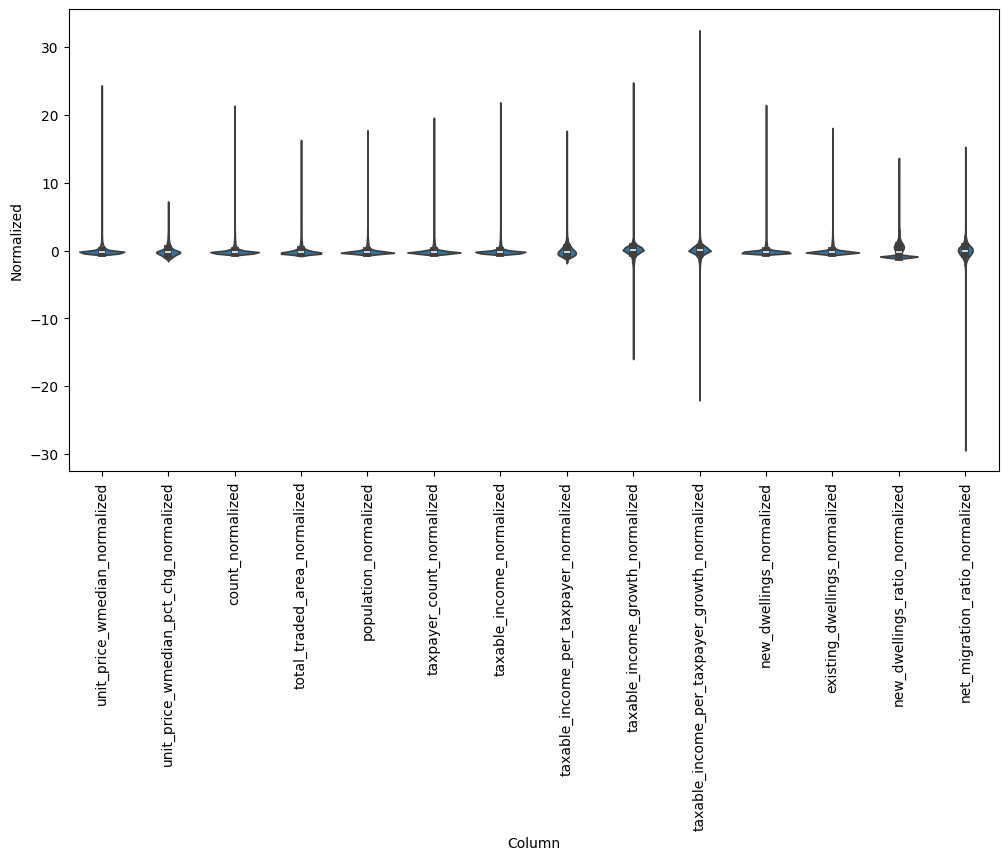

In [195]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [196]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

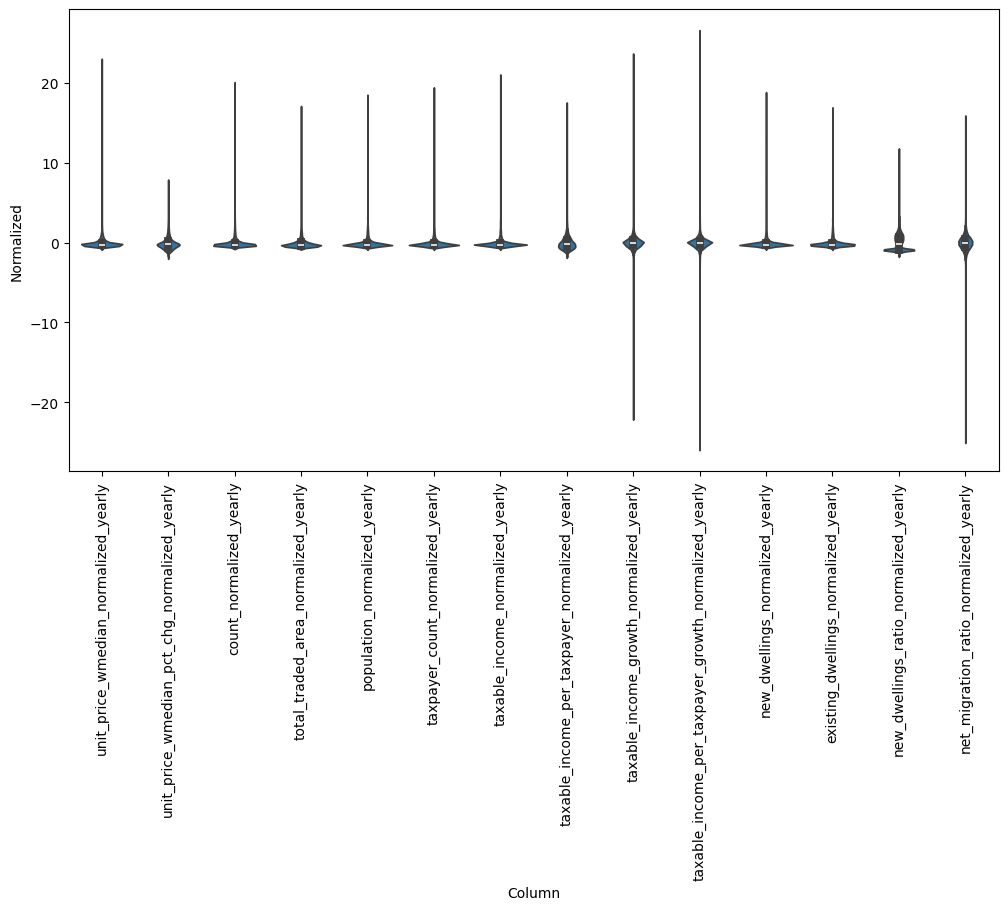

In [197]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [198]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

for i, sample in enumerate(time_series_dataset):
    print(
        i,
        sample["window"].shape,
        sample["target"].shape,
        sample["target"].values,
        sample["weight"].values,
    )
    if i == 3:
        break


for i, sample in enumerate(time_series_dataset_transformed):
    print(
        i,
        sample["window"].shape,
        sample["target"].shape,
        sample["target"],
        sample["weight"],
    )
    if i == 3:
        break

0 (0, 15) (1,) [-1.19561809] [1.33799908]
1 (0, 15) (1,) [-0.82436338] [1.0192749]
2 (0, 15) (1,) [0.24988835] [1.1018816]
3 (0, 15) (1,) [0.11173409] [1.16796696]
0 torch.Size([5, 32]) torch.Size([1]) tensor([-1.1956]) tensor([1.3380])
1 torch.Size([5, 32]) torch.Size([1]) tensor([-0.8244]) tensor([1.0193])
2 torch.Size([5, 32]) torch.Size([1]) tensor([0.2499]) tensor([1.1019])
3 torch.Size([5, 32]) torch.Size([1]) tensor([0.1117]) tensor([1.1680])


In [199]:
BATCH_SIZE = 256

In [200]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

### Building the Transformer Model

In [201]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [224]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [225]:
%%timeit

model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.2468323707580566
torch.Size([256, 5, 15]) torch.Size([256, 5]) torch.Size([256,

In [226]:
# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping and regularization so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary

def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

# loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
# model.load_state_dict(loaded_state_dict, strict=False)


In [227]:
learning_rate = 3e-5 # 3e-4
weight_decay = 5
num_epochs = 200

In [228]:
# mse_loss = MSELoss().to(device)
mse_loss_weighted = MSELossWeighted().to(device)

num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [229]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weightless(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weightless(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 3.9579, Eval Loss: 3.7302
Train R^2: 0.0097, Eval R^2: 0.0642
Epoch: 1
Train Loss: 3.6187, Eval Loss: 3.4411
Train R^2: 0.0945, Eval R^2: 0.1382
Epoch: 2
Train Loss: 3.5001, Eval Loss: 3.3388
Train R^2: 0.1242, Eval R^2: 0.1636
Epoch: 3
Train Loss: 3.4617, Eval Loss: 3.3108
Train R^2: 0.1338, Eval R^2: 0.1704
Epoch: 4
Train Loss: 3.4360, Eval Loss: 3.2950
Train R^2: 0.1402, Eval R^2: 0.1740
Epoch: 5
Train Loss: 3.4126, Eval Loss: 3.2892
Train R^2: 0.1461, Eval R^2: 0.1752
Epoch: 6
Train Loss: 3.3908, Eval Loss: 3.2853
Train R^2: 0.1515, Eval R^2: 0.1759
Epoch: 7
Train Loss: 3.3729, Eval Loss: 3.2817
Train R^2: 0.1560, Eval R^2: 0.1766
Epoch: 8
Train Loss: 3.3582, Eval Loss: 3.2820
Train R^2: 0.1597, Eval R^2: 0.1763
Epoch: 9
Train Loss: 3.3453, Eval Loss: 3.2837
Train R^2: 0.1629, Eval R^2: 0.1758
Epoch: 10
Train Loss: 3.3337, Eval Loss: 3.2869
Train R^2: 0.1658, Eval R^2: 0.1749
Epoch: 11
Train Loss: 3.3233, Eval Loss: 3.2911
Train R^2: 0.1684, Eval R^2: 0.1738
Ep

KeyboardInterrupt: 

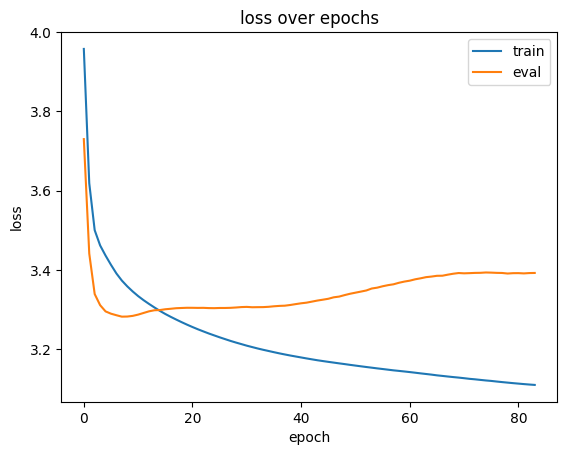

In [230]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

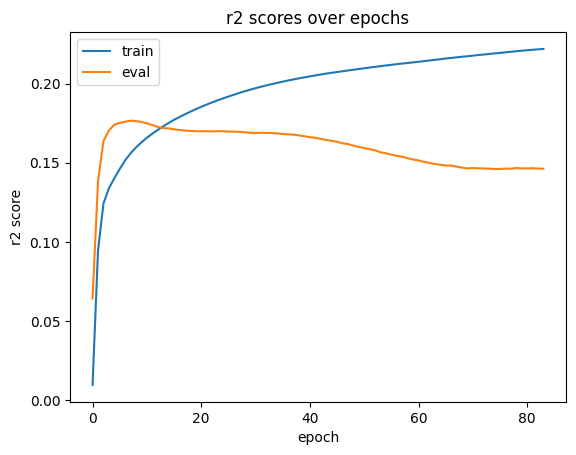

In [231]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [32]:
# untrained model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4521
Eval R2: 0.1688


### Pretraining and transfer gameplan

Within my time series model, I have the Transformer Encoder and the Positional Encoder. 
Once the model is done training, I will take the weights and save it to a file.
Then, I will load up the new model with this file.



In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

### The High Variance Problem

The model is overfitting right now